In [1]:
import nengo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

%matplotlib inline

In [2]:
?nengo.utils.ensemble.tuning_curves

Signature: nengo.utils.ensemble.tuning_curves(ens, sim, inputs=None)
Docstring:
Calculates the tuning curves of an ensemble.

That is the neuron responses in dependence of the vector represented by the
ensemble.

For 1-dimensional ensembles, the unpacked return value of this function
can be passed directly to ``matplotlib.pyplot.plot``.

Parameters
----------
ens : nengo.Ensemble
    Ensemble to calculate the tuning curves of.
sim : nengo.Simulator
    Simulator providing information about the built ensemble. (An unbuilt
    ensemble does not have tuning curves assigned to it.)
inputs : sequence of ndarray, optional
    The inputs at which the tuning curves will be evaluated. For each of
    the ``D`` ensemble dimensions one array of dimensionality ``D`` is needed.
    The output of :func:`numpy.meshgrid` with ``indexing='ij'`` is in the
    right format.

Returns
-------
inputs : sequence of ndarray
    The passed or auto-generated ``inputs``.
activities : ndarray
    The activities o

In [13]:
def get_tuning_curves(*args, **kwargs):
    with nengo.Network() as model:
        ens = nengo.Ensemble(*args, **kwargs)     

    with nengo.Simulator(model, progress_bar=False) as sim:
        pass

    if ens.dimensions == 1:
        xs, A = nengo.utils.ensemble.tuning_curves(ens, sim, np.linspace(-1, 1, 200).reshape(-1, 1))
    else:
        xs, A = nengo.utils.ensemble.tuning_curves(ens, sim)
    return xs, A

def get_D(A, ys, sigma=0.5):
    sigma = sigma * np.max(A)
    return np.linalg.lstsq(A.T @ A + np.square(sigma) * np.eye(A.shape[1]), A.T @ ys, rcond=None)[0]

def plot_decoding(ax, xs, A, f, loc=(0.0, 0.75), ymin=-1.25):
    D = get_D(A, f(xs))
    ys = A @ D
    rmse = np.sqrt(np.mean(np.square(f(xs) - ys)))
    ax.plot(xs, f(xs), 'k--', linewidth=1)
    ax.plot(xs, ys)
    ax.text(*loc, 'NRMSE = {:0.2f}'.format(rmse / np.sqrt(np.mean(np.square(f(xs))))), fontsize=8, ha='center')
    ax.set_ylim(ymin, 1.25)

def PCA_SVD(X):
    return np.linalg.svd(X - np.mean(X, axis=0))[1:3]

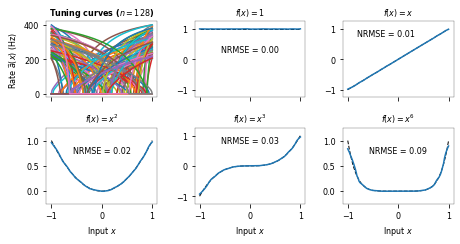

In [187]:
np.random.seed(4891)
xs, A = get_tuning_curves(n_neurons=128, dimensions=1)

fig, axs = plt.subplots(2, 3, figsize=(6.5, 3.5), sharex=True)
axs[0, 0].plot(xs, A)
axs[0, 0].set_title('Tuning curves ($n=128$)')
axs[0, 0].set_ylabel('Rate $\\vec a(x)$ (Hz)')

plot_decoding(axs[0, 1], xs, A, lambda x: np.ones_like(x), loc=(0.0, 0.25))
axs[0, 1].set_title('$f(x) = 1$')

plot_decoding(axs[0, 2], xs, A, lambda x: x, loc=(-0.25, 0.75))
axs[0, 2].set_title('$f(x) = x$')

plot_decoding(axs[1, 0], xs, A, lambda x: x * x, ymin=-0.25)
axs[1, 0].set_title('$f(x) = x^2$')
axs[1, 0].set_xlabel("Input $x$")

plot_decoding(axs[1, 1], xs, A, lambda x: np.power(x, 3))
axs[1, 1].set_title('$f(x) = x^3$')
axs[1, 1].set_xlabel("Input $x$")

plot_decoding(axs[1, 2], xs, A, lambda x: np.power(x, 6), ymin=-0.25)
axs[1, 2].set_title('$f(x) = x^6$')
axs[1, 2].set_xlabel("Input $x$")

fig.tight_layout()
fig.savefig('../poly_decodings.pdf', bbox_inches='tight', transparent=True)

In [188]:
def analyse_tuning_curves(xs, A):
    V, T = PCA_SVD(A.T)

    fig, axs = plt.subplots(1, 3, figsize=(6.5, 2.75))
    axs[0].plot(xs, A);
    axs[0].set_title('Tuning curves ($n=128$)')
    axs[0].set_xlabel('Input $x$')
    axs[0].set_ylabel('Rate $\\vec a(x)$ (Hz)')

    axs[1].plot(xs, T[:6].T / np.max(np.abs(T[:6].T), axis=0));
    axs[1].set_xlabel("Input $x$")
    axs[1].set_title("Principal Components")

    N = 20
    axs[2].plot(np.arange(1, N + 1), np.sqrt(V[:N] / V[0]), 'k--', linewidth=1)
    axs[2].plot(np.arange(1, N + 1), np.sqrt(V[:N] / V[0]), 'o', linewidth=1)
    axs[2].set_ylim(0, 1)
    axs[2].set_xlabel('Dimension $i$')
    axs[2].set_title('Singular values')

    fig.tight_layout()
    return fig, axs

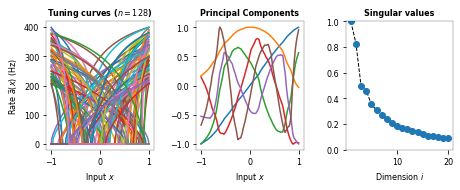

In [189]:
np.random.seed(4891)
xs, A = get_tuning_curves(n_neurons=128, dimensions=1)
fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_lif_pca.pdf', bbox_inches='tight', transparent=True)

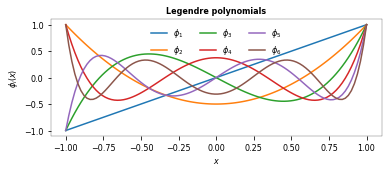

In [190]:
fig, ax = plt.subplots(figsize=(5.5, 2.5))
xs = np.linspace(-1, 1, 100)
for i in range(1, 7):
    ax.plot(xs, np.polynomial.Legendre([0] * i + [1])(xs), label="$\\phi_{}$".format(i))
ax.set_xlabel('$x$')
ax.set_ylabel('$\\phi_i(x)$')
ax.set_title('Legendre polynomials')
ax.legend(loc='best', ncol=3)

fig.tight_layout()
fig.savefig('../legendre.pdf', bbox_inches='tight', transparent=True)

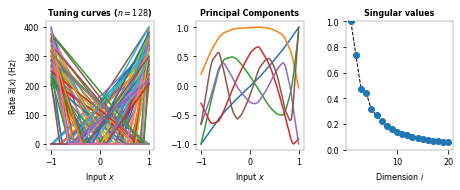

In [191]:
np.random.seed(4891)
xs, A = get_tuning_curves(n_neurons=128, dimensions=1, neuron_type=nengo.RectifiedLinear())
fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_relu_pca.pdf', bbox_inches='tight', transparent=True)

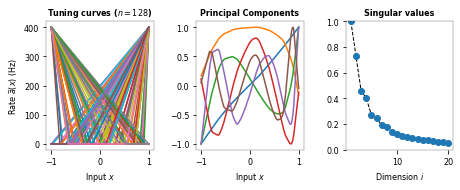

In [192]:
np.random.seed(4891)
xs, A = get_tuning_curves(
    n_neurons=128, dimensions=1,neuron_type=nengo.RectifiedLinear(),
    max_rates=nengo.dists.Uniform(400, 400))
fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_relu_pca_fix_max_rate.pdf', bbox_inches='tight', transparent=True)

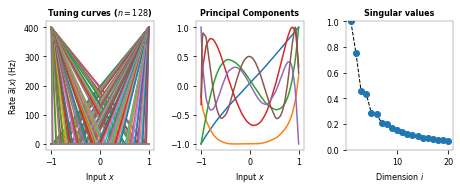

In [193]:
np.random.seed(4891)
xs, A = get_tuning_curves(
    n_neurons=128, dimensions=1,neuron_type=nengo.RectifiedLinear(),
    max_rates=nengo.dists.Uniform(400, 400),
    intercepts=np.linspace(-0.98, 0.98, 128))
fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_relu_pca_fix_max_rate_intercepts_i.pdf', bbox_inches='tight', transparent=True)

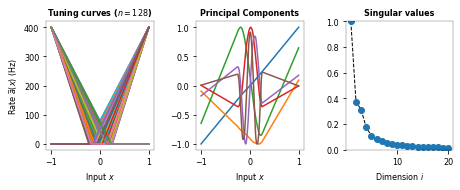

In [194]:
np.random.seed(4891)
xs, A = get_tuning_curves(
    n_neurons=128, dimensions=1,neuron_type=nengo.RectifiedLinear(),
    max_rates=nengo.dists.Uniform(400, 400),
    intercepts=nengo.dists.Uniform(-0.25,0.25))
fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_relu_pca_fix_max_rate_intercepts_ii.pdf', bbox_inches='tight', transparent=True)

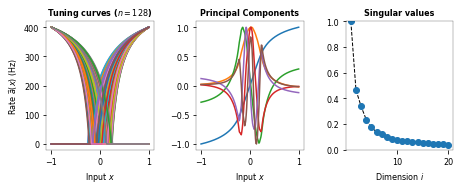

In [195]:
np.random.seed(4891)
xs, A = get_tuning_curves(
    n_neurons=128, dimensions=1,neuron_type=nengo.LIF(),
    max_rates=nengo.dists.Uniform(400, 400),
    intercepts=nengo.dists.Uniform(-0.25,0.25))
fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_lif_pca_fix_max_rate_intercepts.pdf', bbox_inches='tight', transparent=True)

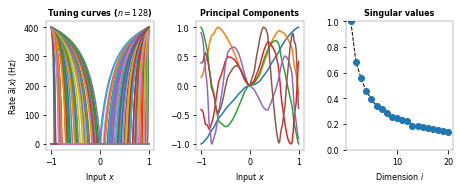

In [196]:
np.random.seed(4891)
xs, A = get_tuning_curves(
    n_neurons=128, dimensions=1,neuron_type=nengo.LIF(),
    max_rates=nengo.dists.Uniform(400, 400),
    intercepts=nengo.dists.Uniform(0.0,0.98))
fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_relu_pca_symmetric.pdf', bbox_inches='tight', transparent=True)

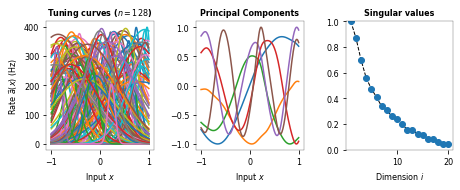

In [181]:
np.random.seed(4891)
N = 128
max_rates = np.random.uniform(200, 400, N)
means = np.random.uniform(-1, 1, N)
sigmas = np.random.uniform(0.1, 1, N)
xs = np.linspace(-1, 1, 200)
A = (max_rates[:, None] * np.exp(-(xs[None, :] - means[:, None]) ** 2 / sigmas[:, None] ** 2)).T

fig, _ = analyse_tuning_curves(xs, A)
fig.savefig('../tuning_curve_gaussian_pca.pdf', bbox_inches='tight', transparent=True)

In [51]:
np.random.seed(4891)
xs, A = get_tuning_curves(
    n_neurons=256, dimensions=2,neuron_type=nengo.LIF())

V, T = PCA_SVD(A.reshape(-1, 256).T)

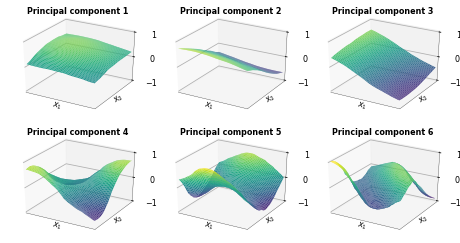

In [85]:
m, n = 2, 3
fig = plt.figure(figsize=(6.5, 3.5))
for i in range(m):
    for j in range(n):
        idx = i * n + j
        ax = fig.add_subplot(m, n, idx + 1, projection='3d')
        ax.plot_surface(
            xs[:, :, 0],
            xs[:, :, 1],
            20 * T[idx].reshape(xs.shape[0], xs.shape[1]),
            cmap=cm.get_cmap('viridis'),
            vmin=-1, vmax=1
        )
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([-1, 0, 1])
        ax.set_zlim(-1, 1)
        ax.set_xlim(-1, 1)
        ax.set_ylim(-1, 1)
        ax.set_xlabel('$x_1$')
        ax.set_ylabel('$x_2$')
        ax.xaxis.labelpad = -17
        ax.yaxis.labelpad = -17
        ax.set_title('Principal component {}'.format(idx + 1))

fig.tight_layout()
fig.savefig('../2d_tuning_curves.pdf', bbox_inches='tight')